# Running simulations of the Foraging Ascomycete Model

<a id='contents'></a>
## contents

[Setup and model defaults](#setup) 

### EC- fungi

[Survival of the...only? dispersal of one fungus.](#onefungus)  

[Changing initial abundances of wood](#initialwood)  

[Effect of wood deposition](#deposition)  

[Basic competition experiments](#basiccomp)

## EC+ fungi

[Endophyte survival](#Endosurv)

[Effect of wood deposition on endophytes](#endo_newwood)

## EC- vs. EC+ fungi

[Endophyte competition experiments](#endocompetition)

[Effects of Endophyte loss](#endoloss)

## Deforestation

[Deforestation](#deforestation)

<a id='setup'></a>
## Setup and model defaults

In [4]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from FAmodel import Forest
from FAmodel import sumendos
from FAmodel import sumdecomps
from FAagents import Tree, Wood, Fungus
import thomasprocess as tp
import  plotparsers as pr

%matplotlib inline

The defaults for the model. The various simulations to follow vary one or a few of these at a time:

parameter | level | explanation
---|---|---
endophytism | True | allow endophyte life style in model run
ws | 30 | initial num of wood
endodisp|2.0 | dispersal of endos
decompdisp|10.0 | dispersal of decomps
leafdisp | 4.0 | how well do leaves disperse
leaffall | 1 | how frequently do leaves disperse
numdecomp|1 | initial number of decomposers
numendo|1   | initial number of endos
endoloss|0.05   | rate of loss of endophyte infect per step
newwood | 15 | total energy added in new logs each step
woodfreq | 1 | how often to put new logs onto the landscape
width | 100 | grid dimensions only one (squares only)
kappa | 0.03 | average rate of parent tree clusters per unit distance
sigma | 3.0 | variance of child tree clusters +/- spread of child clusters
mu | 2.2 | average rate of child tree clusters per unit distance
nuke | False | make landscape but no agents


[back to contents](#contents)

<a id='onefungus'></a>

## Survival of the...only?

For our first parameter sweep, let's see what it takes to get established as a decomposer fungus new to an area that has recently been subject to nasty storm, with lots of wind-throw. This could represent a little bit of an ecological disturbance, blowing in fungal spores from far-away and a lot of fresh wood, with reduced loads of decomposer fungi on them. 

To model this, we keep the [model defaults](#setup) of a fair amount of initial wood present on the landscape (ws = 30), and then a steady, lower rate of wood deposition from this point on. Our single species of fungus is not endophyte competent (EC-). We'll sweep the coefficient of dispersal for this fungus, from 1 to 15. Our aciss scripts look like this, with the decompdist incremented up to 15:

In [ ]:
mpiexec -n 10 python3 runFA.py -sims 10 -decompdisp 1   -numendo 0 -fileout sweeps/results/onefungusdisp/disp1/onefungusdisp1

In [21]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/onefungusdisp/onefungusdisp.p')

In [22]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

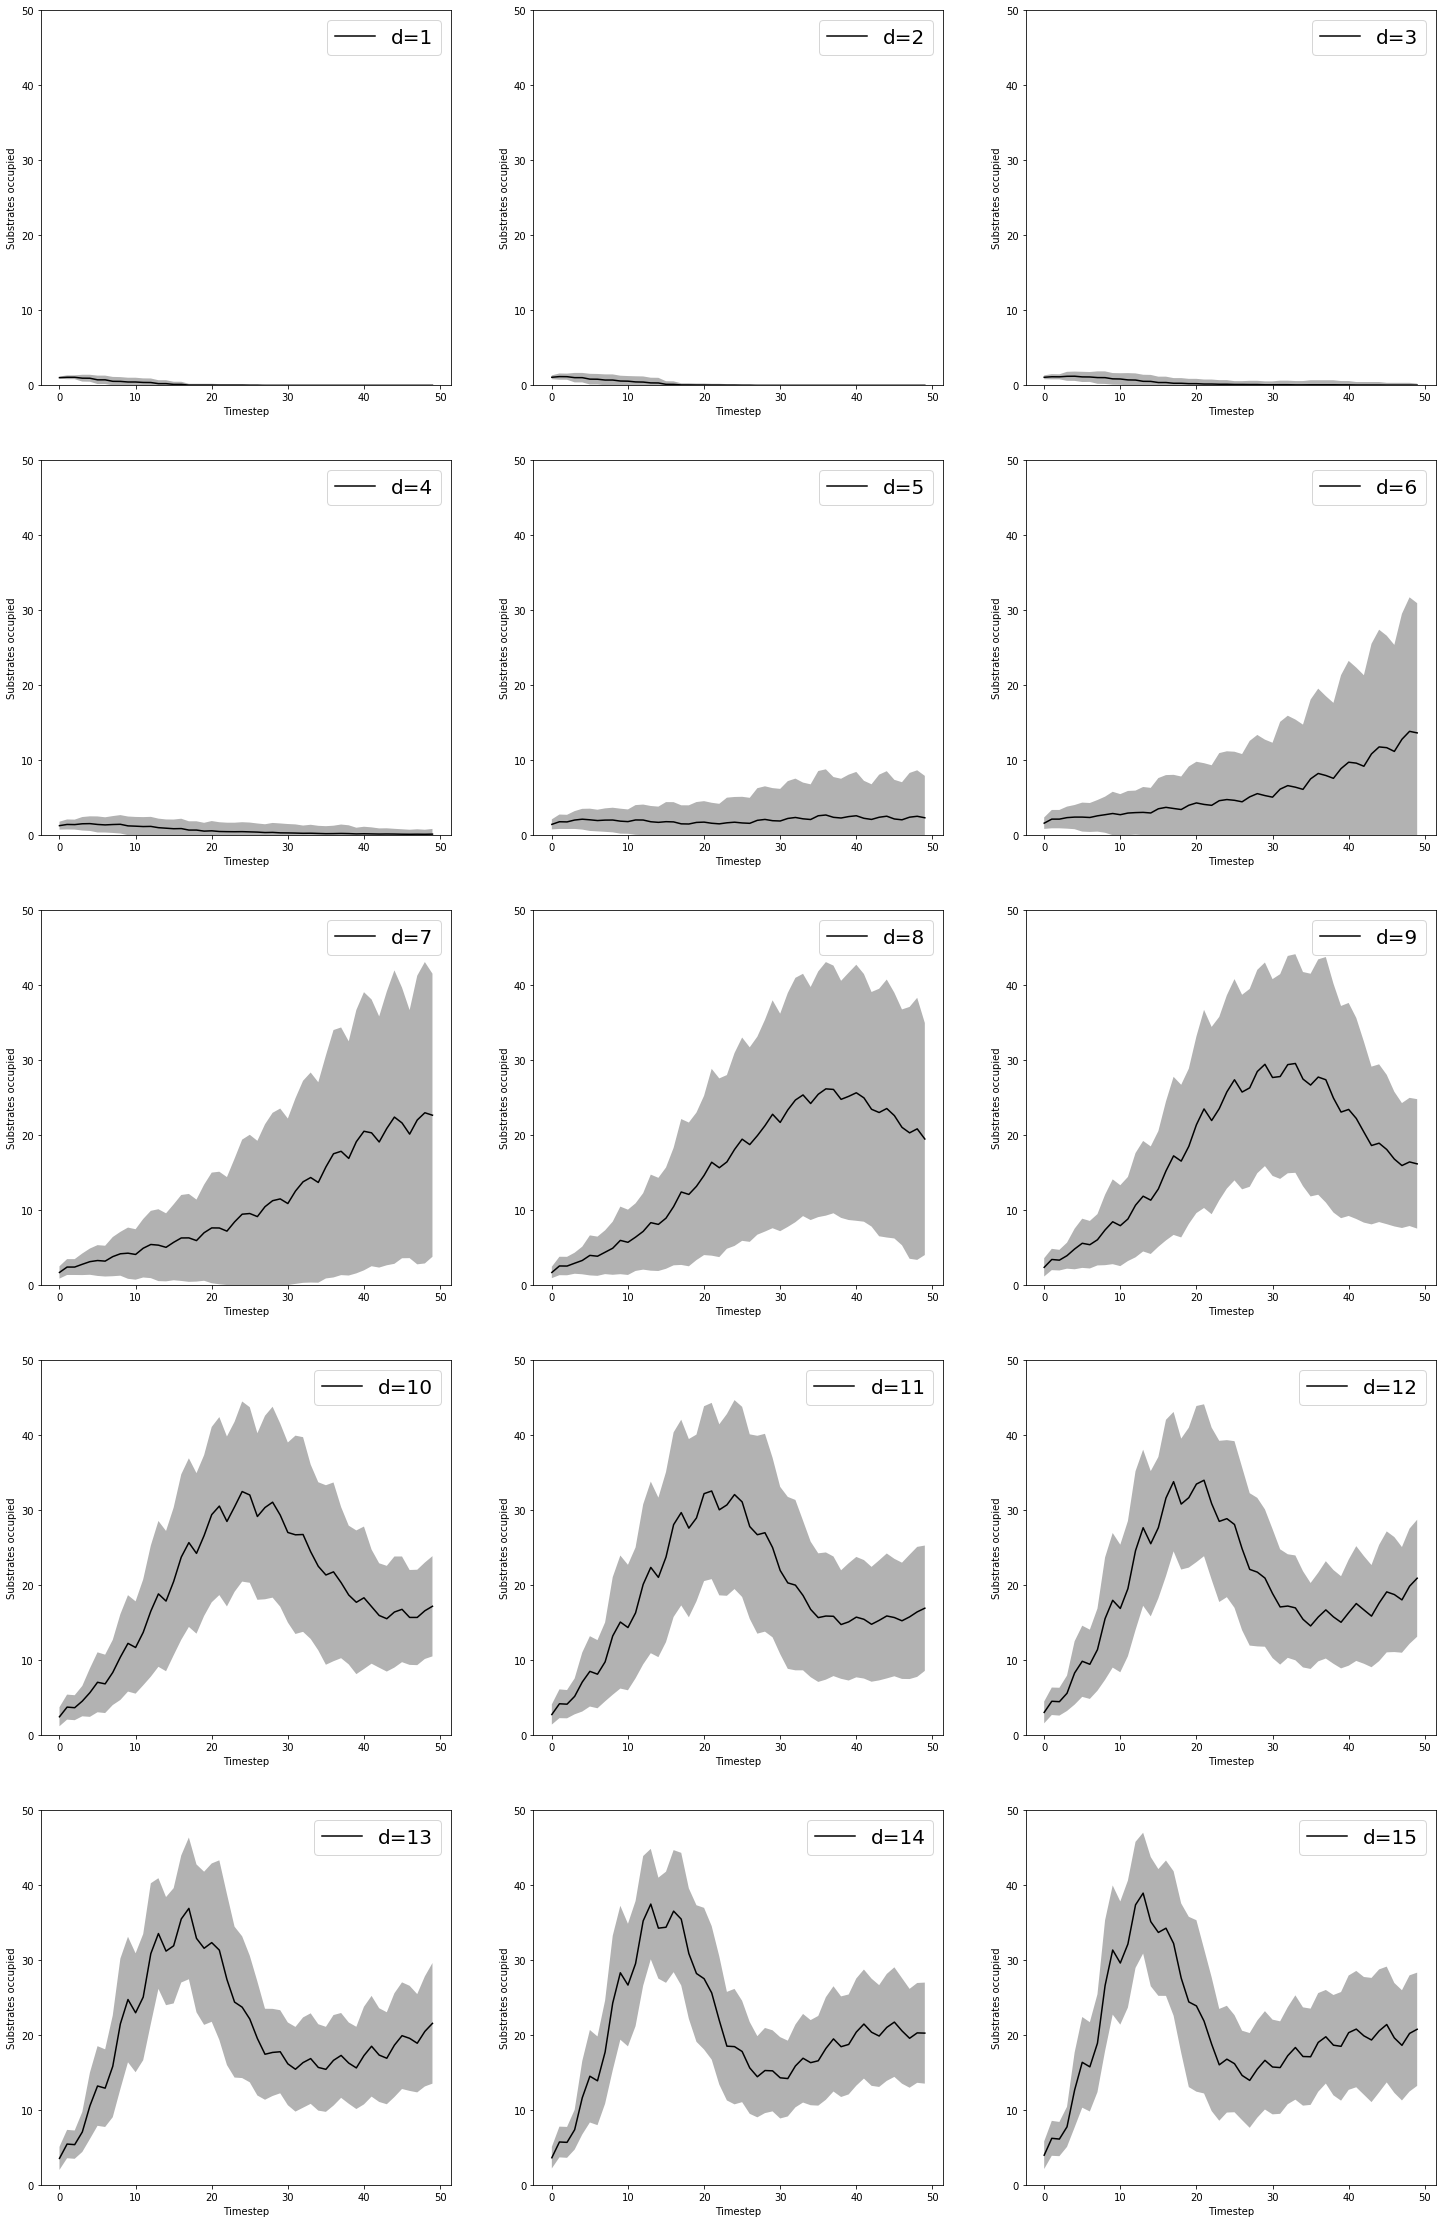

In [24]:
x = list(range(50))
fig, axes = plt.subplots(5,3, figsize=(25, 40)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_ylim(0,50) ## yaxis
    ## plot fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='black',
            label=('d=%s' %lvls[i]),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='black',
                    alpha = 0.3,
                    )
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")


Looks like it take at least a dispersal coefficient of 8 to survive reliably on the landscape. But at d=8, it looks like much initial wood remains, so d=8 probably isn't an incredibly competitive dispersal coefficient. At d=10, the initial wood is consumed, and an equilibrium around the rate of wood deposit is achieved. There is little risk during the "lift-off" phase at d=10, also. So let's set this dispersal as our default aggressive decomposer species.

[back to contents](#contents)

<a id='initialwood'></a>

## Changing initial abundances of wood


We can hold the default EC- dispersal coefficient constant and vary the wood initial abundance and wood-deposition rates. So first, what will it look like if we vary initial abundances of wood?

In [2]:
## aciss:
mpiexec -n 10 python3 runFA.py -sims 10 -ws 10 -numendo 0 -fileout /home6/dthomas/FAsims/FA_ABM/sweeps/results/initwood/ws10

In [27]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/initwood/initwood.p')

In [28]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

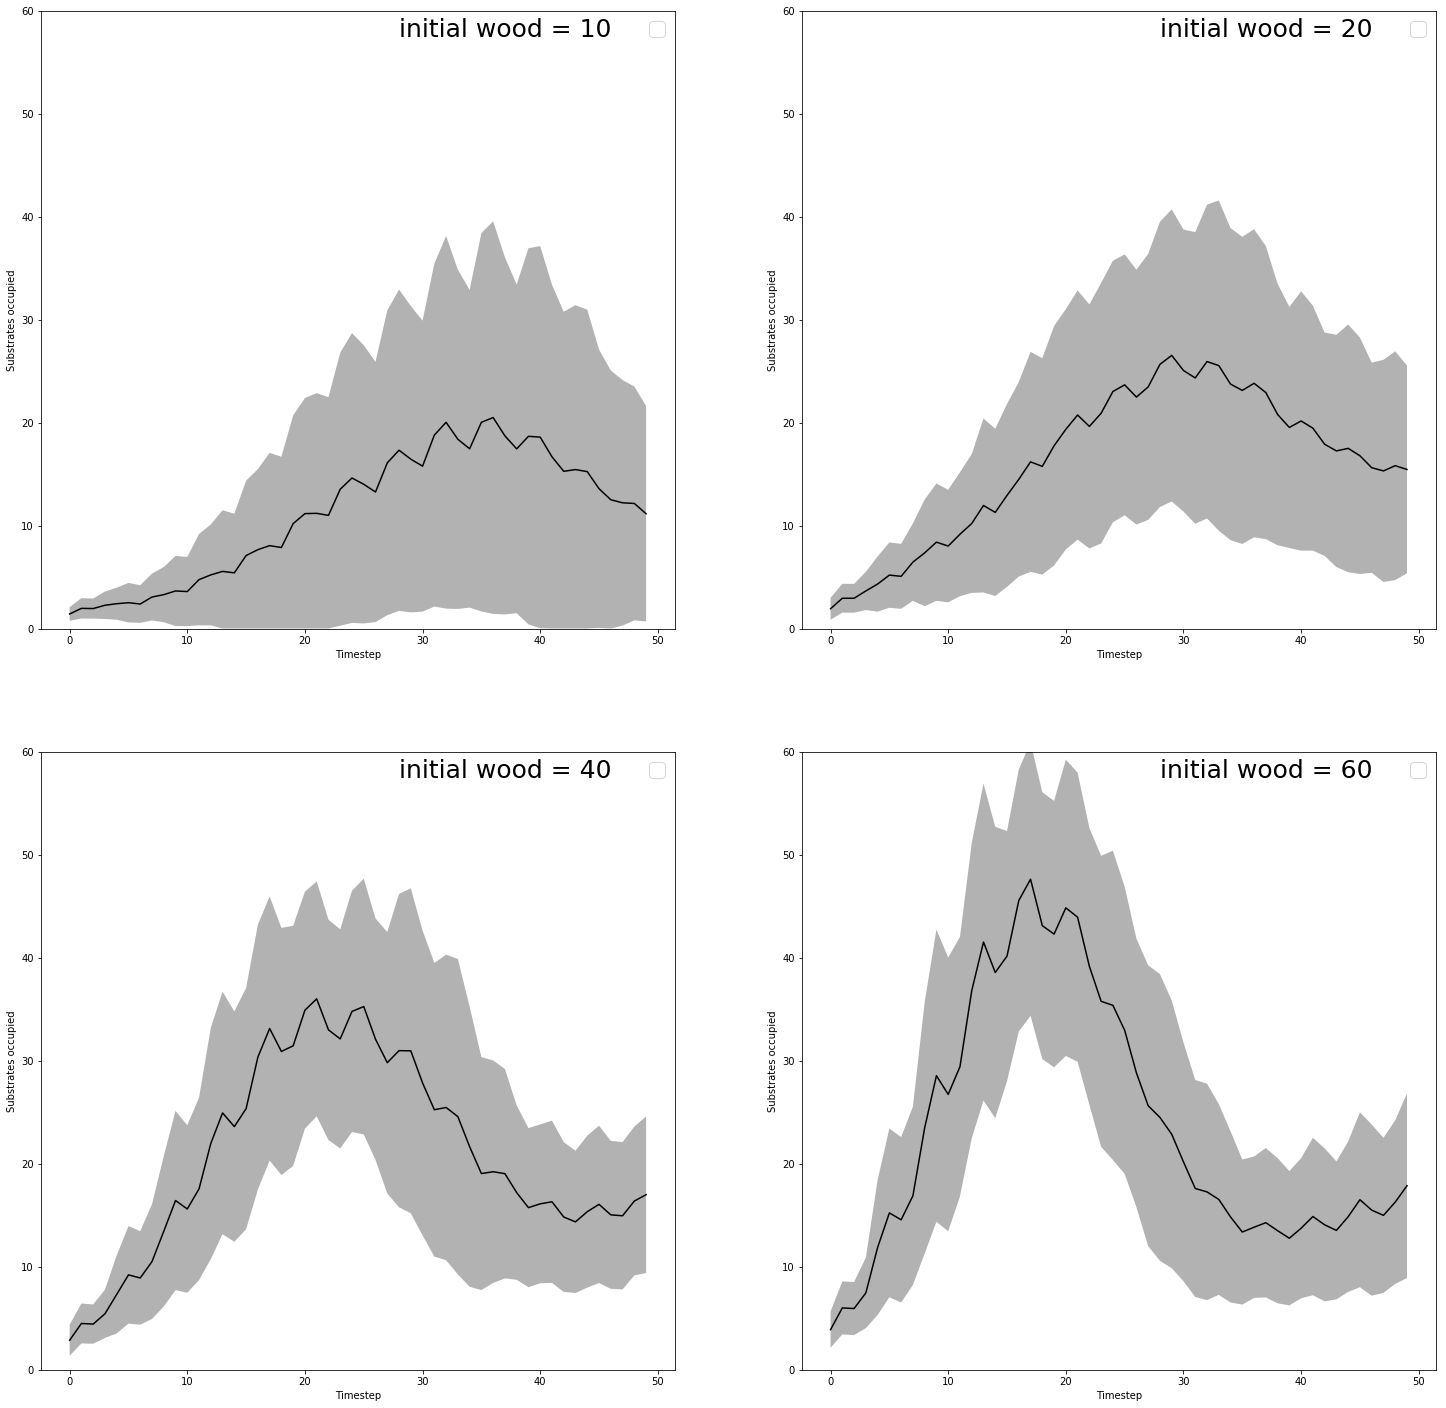

In [43]:
x = list(range(50))
fig, axes = plt.subplots(2,2, figsize=(25, 25)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_ylim(0,60) ## yaxis
    ## plot fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='black',
            #label=('initial=%s' %lvls[i]),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='black',
                    alpha = 0.3,
                    )
    z.text(0.90, 0.95, 'initial wood = %s' %lvls[i] +"0",
            verticalalignment='bottom', horizontalalignment='right',
            transform=z.transAxes,
            color='black', fontsize=25)
    
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")


Huh. If I have time, rerun these with more than 50 steps. In general, if there is wood out there, a well-dispersed fungus will get it, then equilibriate to the steady state of wood as it falls.

[back to contents](#contents)

<a id='deposition'></a>
## Effect of wood deposition rates

Here we assume an initial wood amount of 30 logs on the site, a medium-strong dispersing fungus (not endophyte-competent), and sweep over the rate of new wood deposition on the landscape. Note we aren't varying the frequency here of new log deposition, it is kept the current model default of new wood every step (there is a parameter for this, can be changed, see [defaults](#setup)). The amount of logs that are being dropped over the landscape are being varied.

In [ ]:
## aciss
mpiexec -n 10 python3 runFA.py -sims 10 -newwood 2  -numendo 0 -fileout /home6/dthomas/FAsims/FA_ABM/sweeps/results/newwood/newwood2/

In [44]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/newwood/newwood.p')

In [45]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

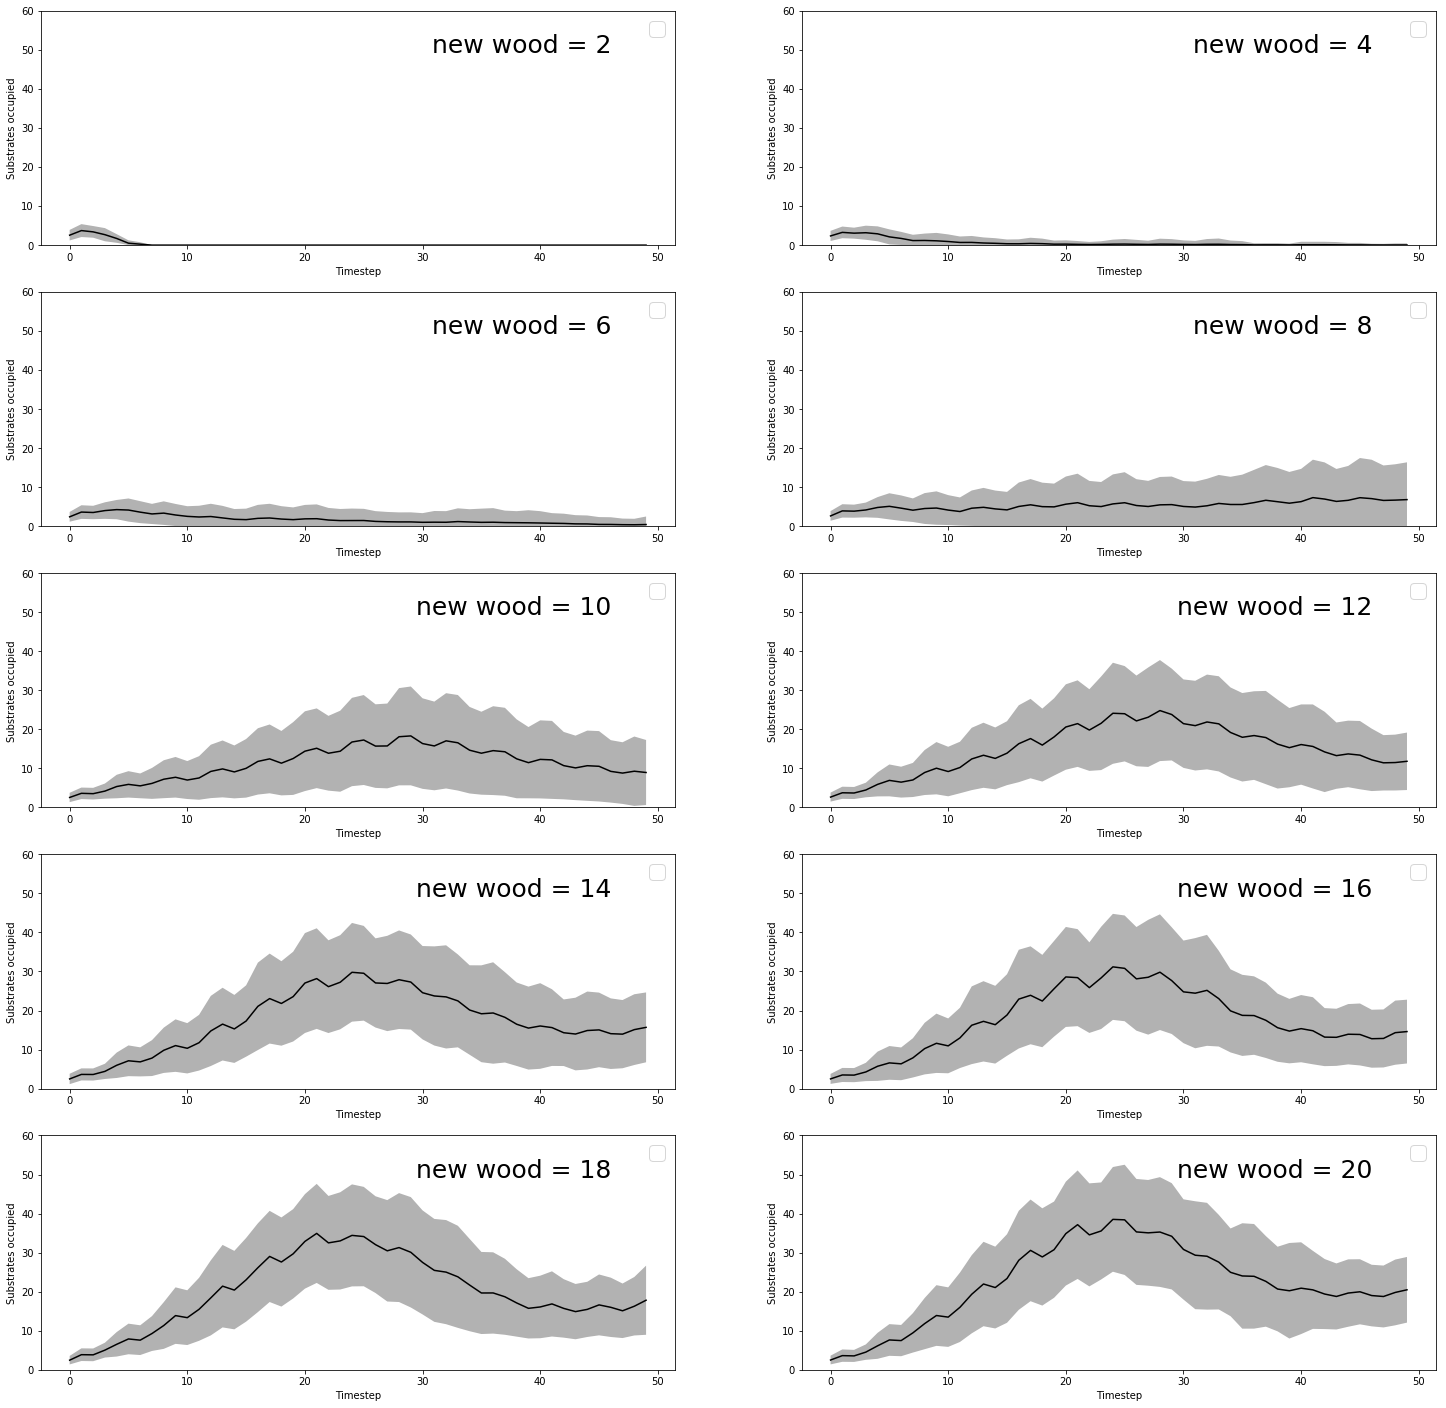

In [52]:
x = list(range(50))
fig, axes = plt.subplots(5,2, figsize=(25, 25)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_ylim(0,60) ## yaxis
    ## plot fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='black',
            #label=('initial=%s' %lvls[i]),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='black',
                    alpha = 0.3,
                    )
    z.text(0.90, 0.80, 'new wood = %s' %lvls[i],
            verticalalignment='bottom', horizontalalignment='right',
            transform=z.transAxes,
            color='black', fontsize=25)
    
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")


It looks like with the forest and fungi we've built, an EC- fungus needs a regular supply of at least 12 or 14 in wood energy deposited each step to survive. With less than than this, we have some level of starvation.   It may interesting to run these simulations on an EC+ fungus, it seems likely that EC+ fungi could persist on the landscape with less fallen wood. 

[back to contents](#contents)

<a id='basiccomp'></a>
## Basic competition experiments

Let's examine what happens when we compete two fungi, not endophyte-competent. We'll hold one species' dispersal ability constant at d=10, and vary the other's from 1 to 14. 

In [97]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/EC-EC-comp/EC-EC-comp.p')

In [98]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

[back to contents](#contents)

<a id='Endosurv'></a>
## Endophyte survival

Let's see how endophytes survive on the landscape, if we give leaves from trees a dispersal coefficient of 4 ([see notes on this](#)). As above we start with the model defaults. From here on, the sweeps are too expensive to be run serially, use mpi on aciss to handle them, even patches. 

So let's run a sweep of endophyte dispersal coefficients, from 1 to 12. 

In [ ]:
mpiexec -n 11 python3 runFA.py -sims 10 -endodisp 1 -endophytism True -fileout '/home6/dthomas/FAsims/FA_ABM/sweeps/results/decomp_comp/disp1/disp1'

In [53]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/endo_disp/endodisp.p')

In [54]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

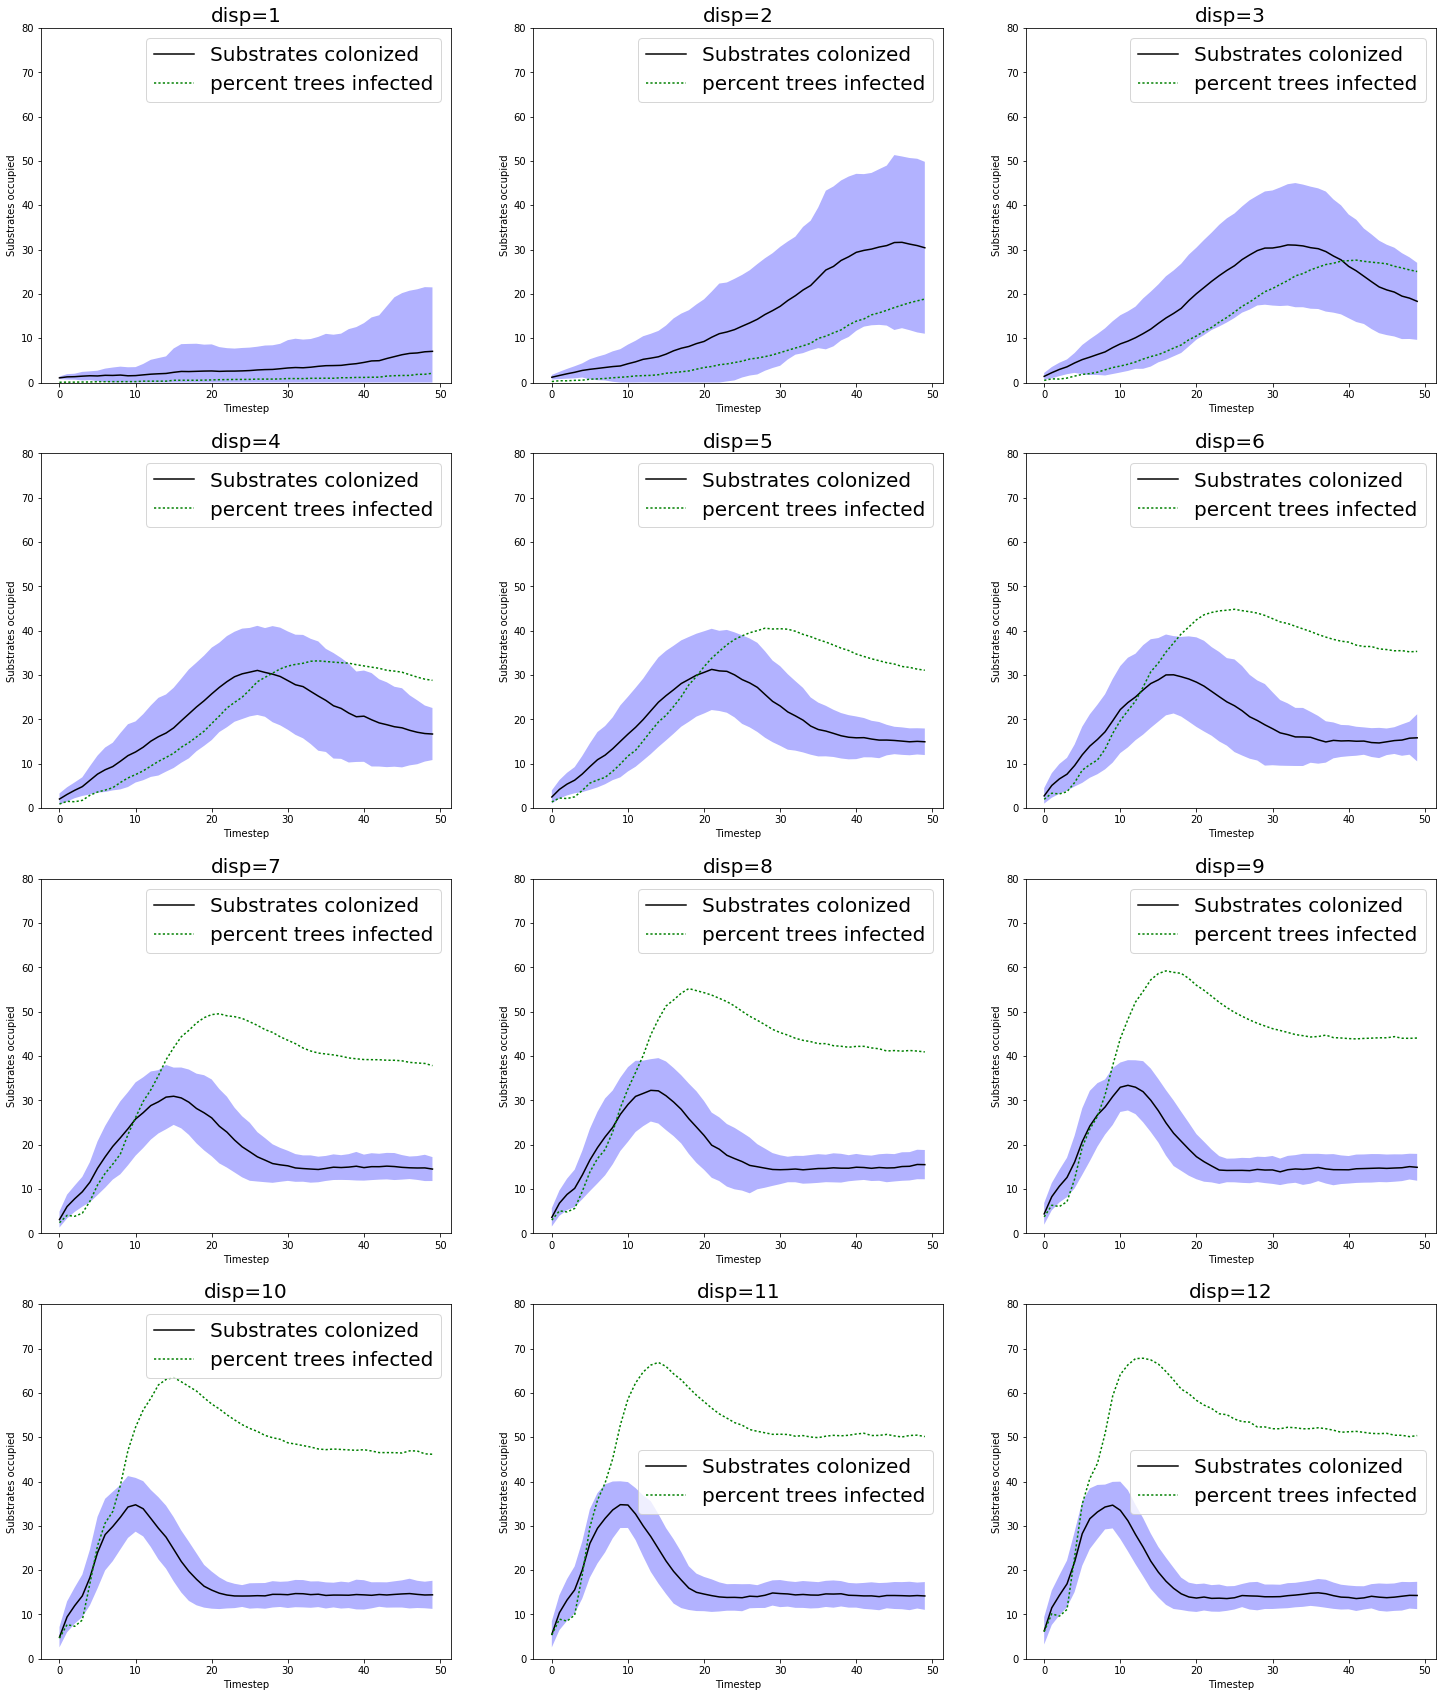

In [83]:
x = list(range(50))
fig, axes = plt.subplots(4,3, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    z.set_ylim(0,80) ## yaxis
    ## plot fungus:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='black',
            label=('Substrates colonized'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    ## trees infected:
    z.plot(x, treepercent,
            ':',
            label=('percent trees infected'),
            c='green',
          )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    z.set_title('disp=%s' %lvls[i], {'fontsize':20})


Even with a pretty low rate of endophyte loss (5% per step), the endophytes in the trees are affected by the amount of litter on the forest floor. 

Interesting. Under these, being an endophyte is useful quickly. Even fungus that can only disperse it's spores at disp=1 to persist on the landscape much of the time, in the dense forest scenario we are using. Notice also that even with the low default rate of endophyte loss (5% per step), the abundance of endophyte-stage fungi is sensitive to the patterns of woody debris on the forest floor.  

[back to contents](#contents)

<a id='endo_newwood'></a>

## Effect of wood deposition on endophytes

Does having an endophytice phase in your lifestyle change your relationship to wood? Sweeping the rate of deposition of new wood on the landscape, with only an EC+ fungus. 

In [ ]:
mpiexec -n 11 python3 runFA.py -numdecomp 0 newwood 2 -sims 10 -fileout /home6/dthomas/FAsims/FA_ABM/sweeps/results/endo_newwood/newwood10/newwood2

In [106]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/endo_newwood/endo_newwood.p')

In [107]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

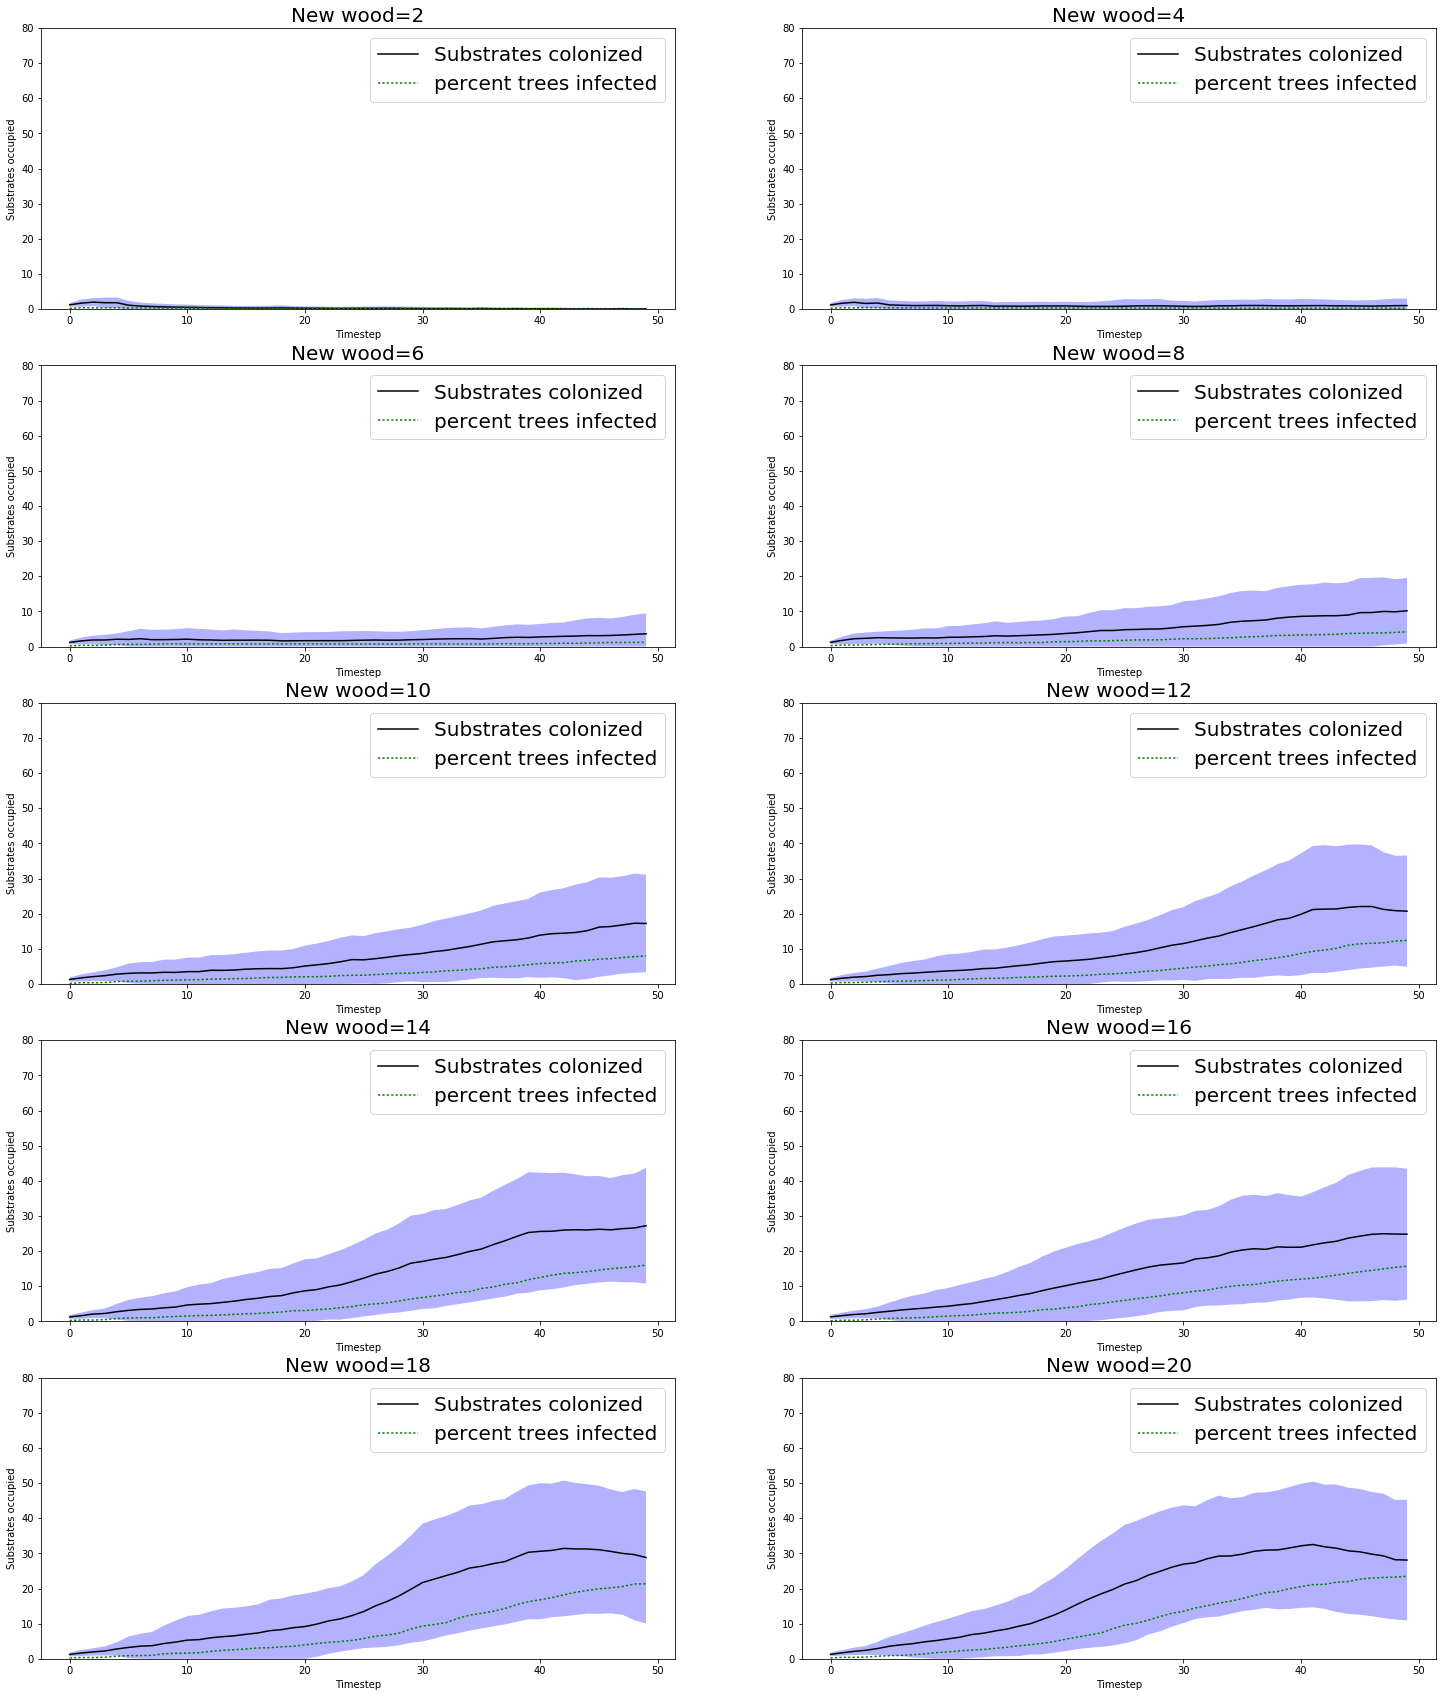

In [110]:
x = list(range(50))
fig, axes = plt.subplots(5,2, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    z.set_ylim(0,80) ## yaxis
    ## plot fungus:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='black',
            label=('Substrates colonized'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    ## trees infected:
    z.plot(x, treepercent,
            ':',
            label=('percent trees infected'),
            c='green',
          )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    z.set_title('New wood=%s' %lvls[i], {'fontsize':20})


<a id='endocompetition'></a>

## Endophyte competition experiments

Now let's see if endophytes-competent fungi (EC+) can compete against more aggressive decomposer (EC-) fungi. In this sweep, we hold an EC- fungus constant at the default disp=10, and increment EC+ fungi from 1 to 12. The instructions to aciss for the first level (EC+ disp=1, EC- disp=10) look like this: 

In [ ]:
mpiexec -n 10 python3 runFA.py -endodisp 1 -sims 10  -fileout ##...

In [117]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/endodecomp_comp/endodecomp_comp.p')

In [118]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

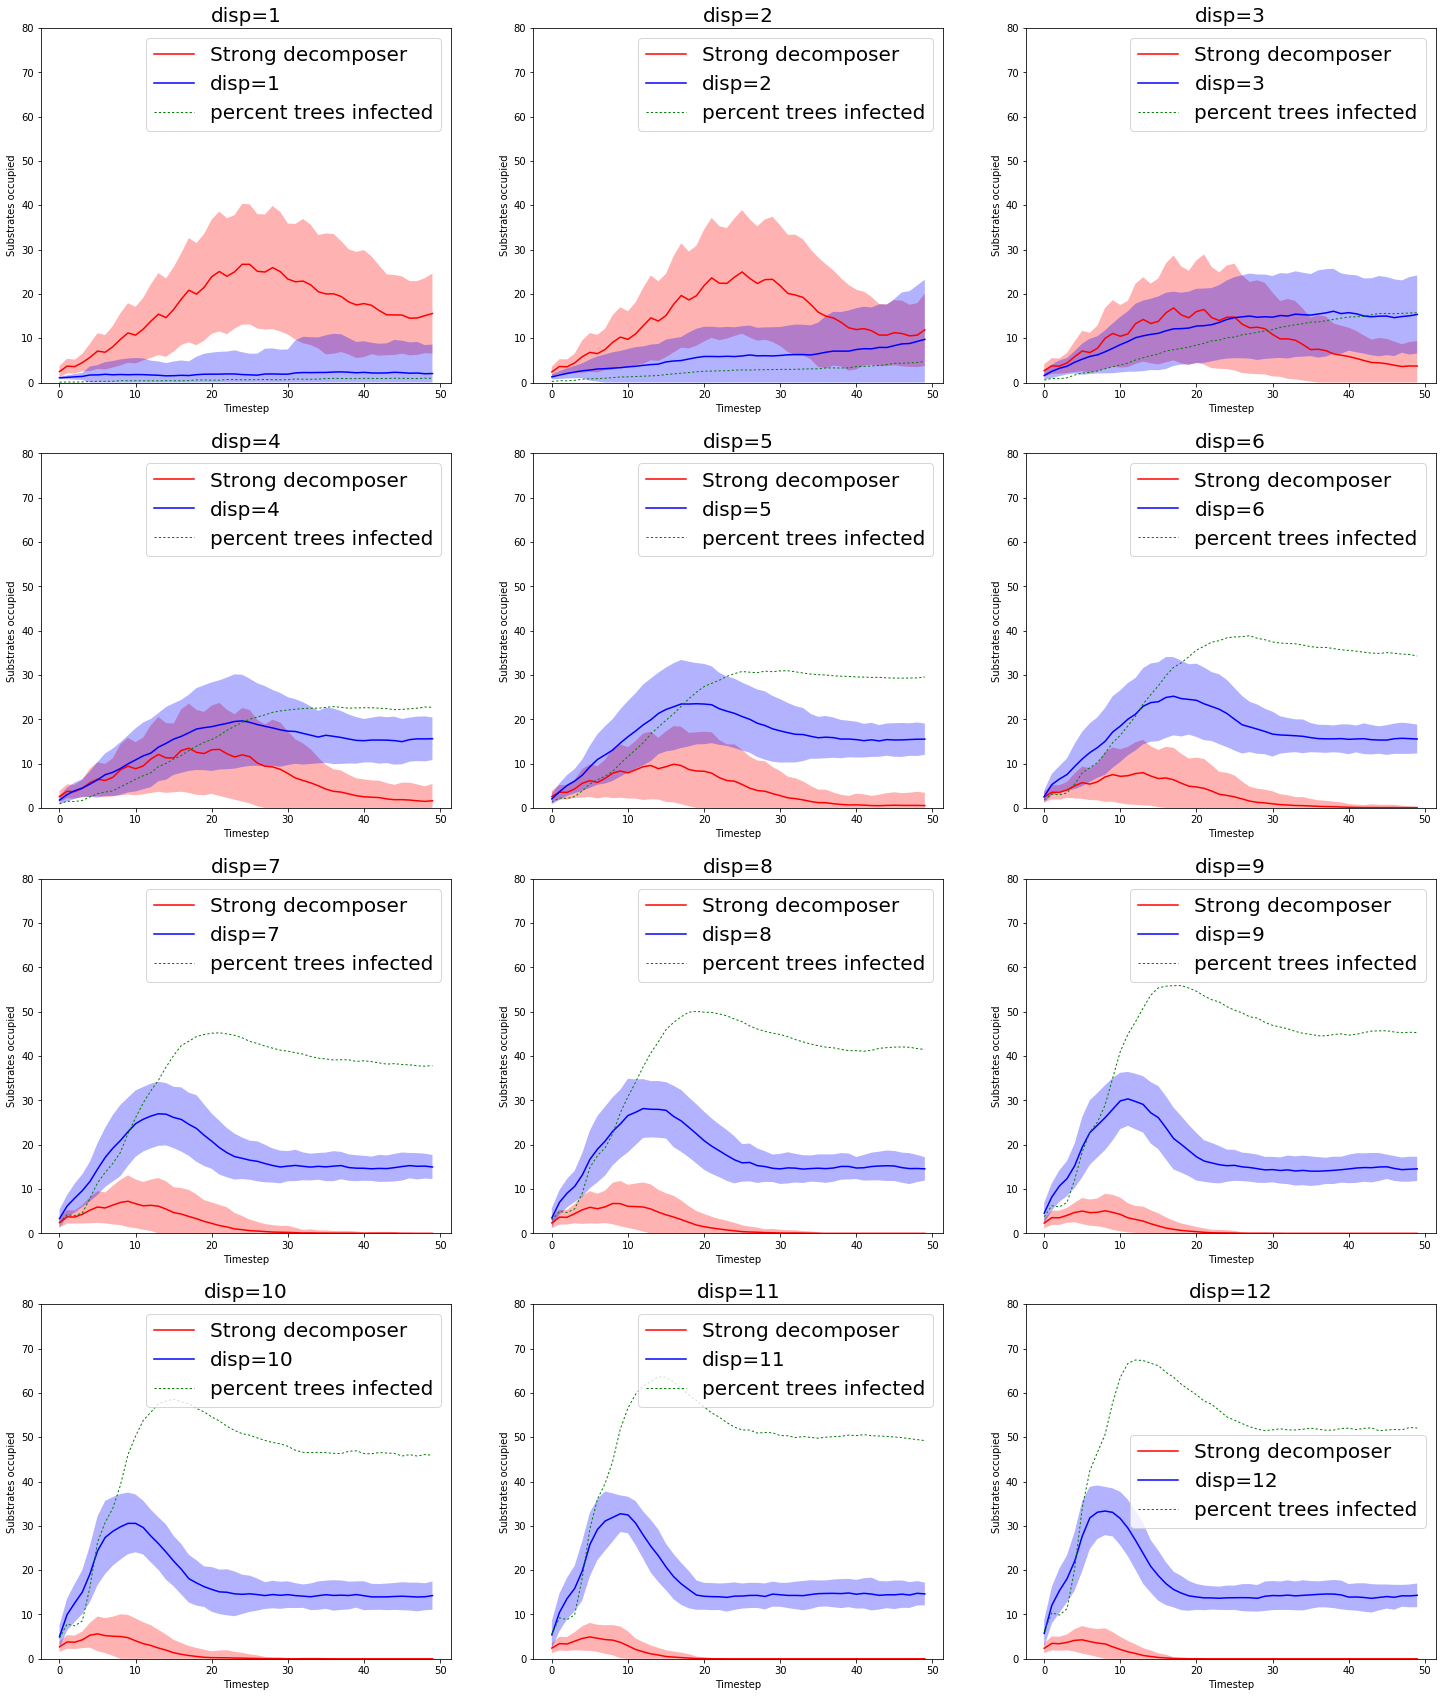

In [120]:
x = list(range(50))
fig, axes = plt.subplots(4,3, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    z.set_ylim(0,80) ## yaxis
    
    ## plot red fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='red',
            label=('Strong decomposer'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='red',
                    alpha = 0.3,
                    )
    
        ## plot blue fungus:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='blue',
            label=('disp=%s' %lvls[i]),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    
    ## trees infected:
    z.plot(x, treepercent,
            ':',
            linewidth=1,
            label=('percent trees infected'),
            c='green',
          )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    z.set_title('disp=%s' %lvls[i], {'fontsize':20})


Under default settings, the endophytic lifestyle seems to be pretty beneficial. Even at EC-disp=2/EC+=disp10 we have endophytes persisting on the landscape. At EC-disp=3/EC+disp=8, endphytism becomes a clear advantage, and beyond this the EC+ species totally outcompetes the EC-. 

[back to contents](#contents)

<a id='endoloss'></a>
## Effect of endophyte loss

The residence time of endophytes in host trees isn't really understood and probably varies wildly with species of host and microbe. The defaults are set at endoloss=0.05, so that every infected tree has a 5% chance of losing it's infection. Our model defaults give EC+ fungi a strong advantage at disp=3, over default EC- fungi (disp=10). But loss of endophyte infection by trees if fairly low in defaults, and we don't know how sensitive endophyte competitiveness is to the rate of endophyte loss. We'll increment the rate of endophyte loss from 0 to 90%. 

In [ ]:
#aciss
mpiexec -n 11 python3 runFA.py -sims 10 -endodisp 3 -endoloss 0   -endophytism True  -fileout /home6/dthomas/FAsims/FA_ABM/sweeps/results/endoloss/endoloss0/endoloss0

In [111]:
runs = pd.read_pickle('/home/daniel/Documents/ABM/FA/sweeps/results/endoloss/endoloss.p')

In [112]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pr.pldata(runs, i) 

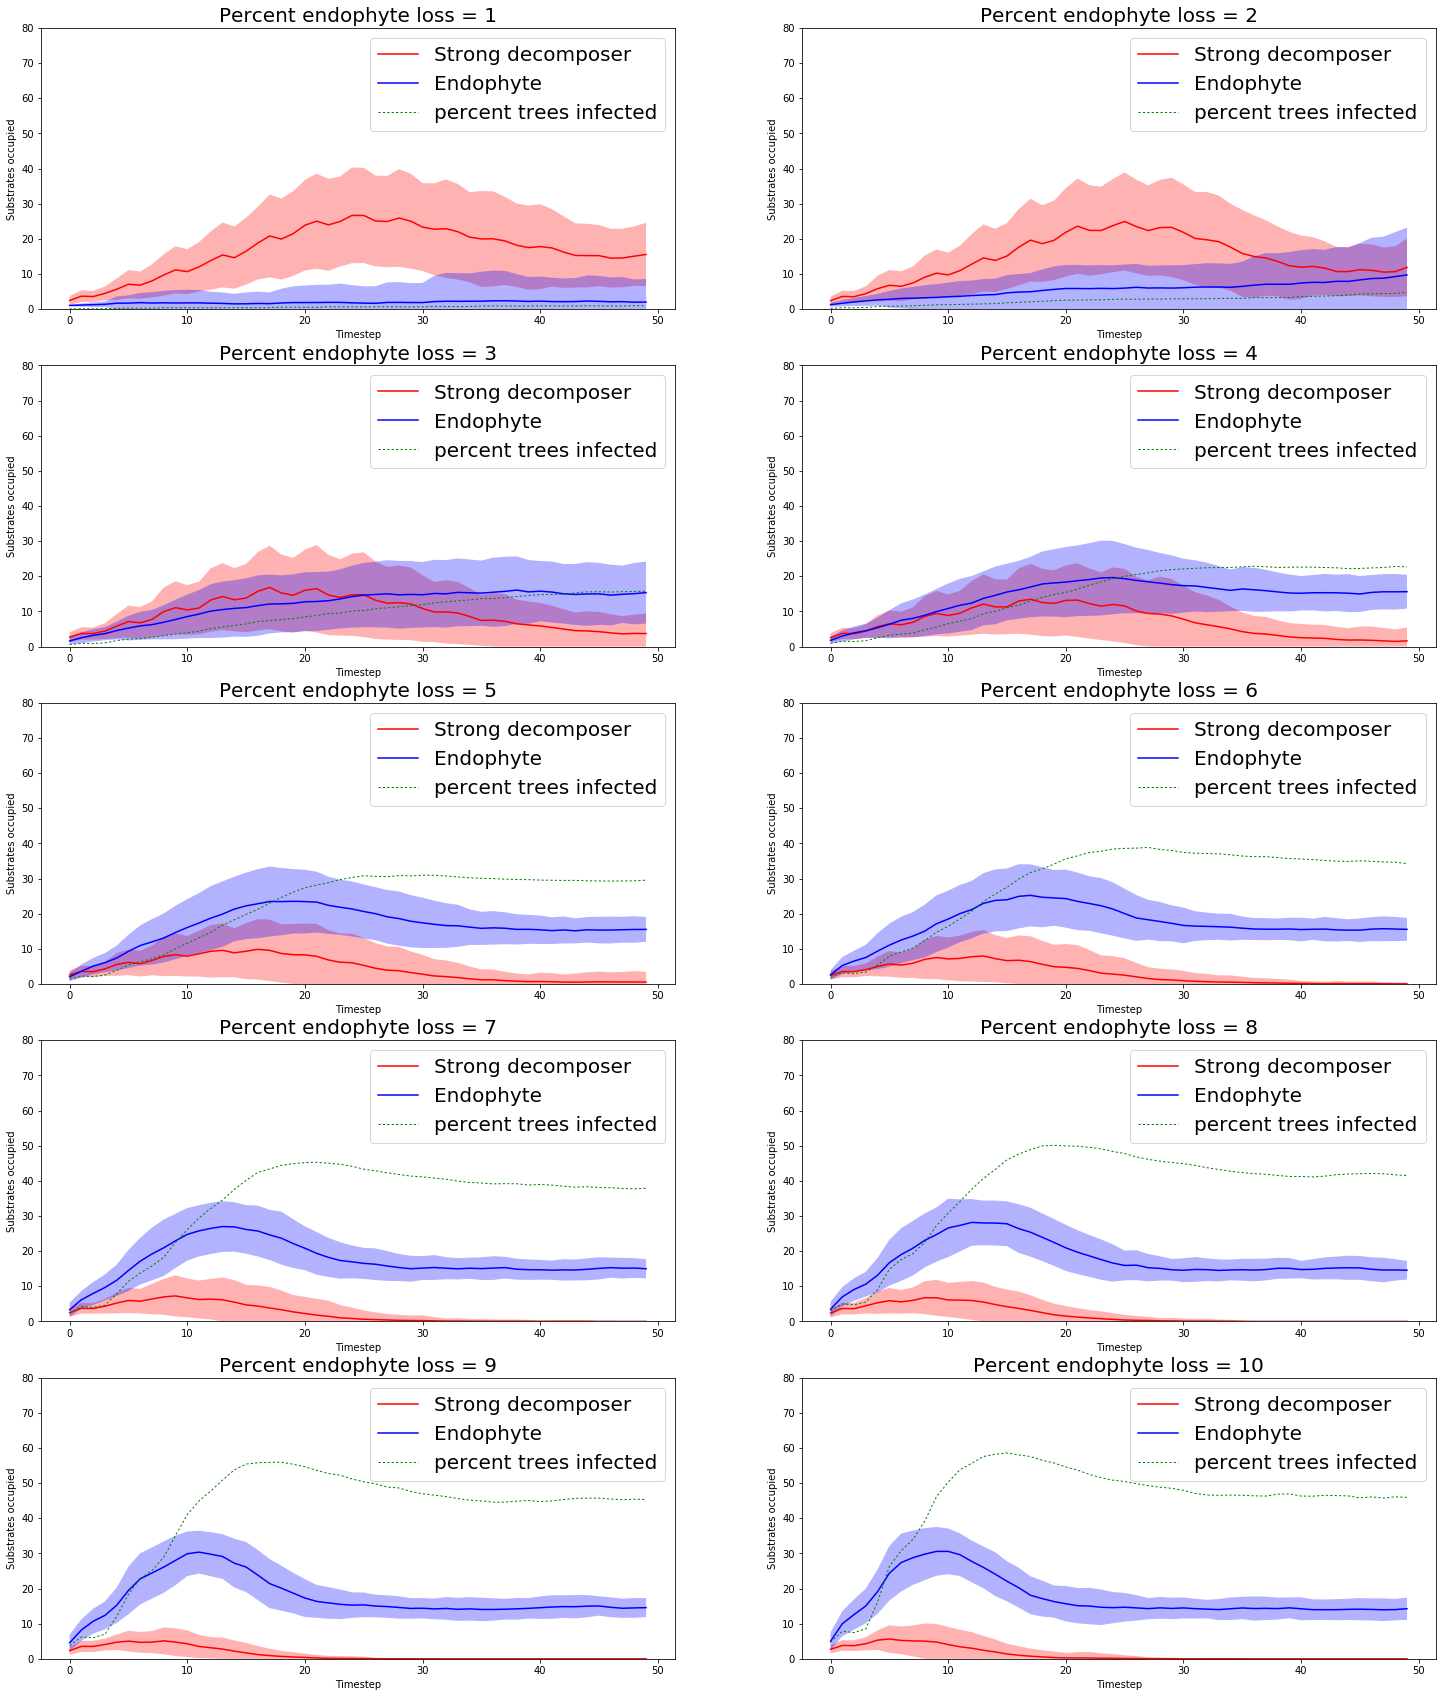

In [121]:
x = list(range(50))
fig, axes = plt.subplots(5,2, figsize=(25, 30)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    treepercent=[ (i/634)*100 for i in runplotdata[lvls[i]]['inf_trees_means'] ] ## convert mean trees to %
    z.set_ylim(0,80) ## yaxis
    
    ## plot red fungus:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
           c='red',
            label=('Strong decomposer'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='red',
                    alpha = 0.3,
                    )
    
        ## plot blue fungus:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
           c='blue',
            label=('Endophyte'),
            )
    ## error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    
    ## trees infected:
    z.plot(x, treepercent,
            ':',
            linewidth=1,
            label=('percent trees infected'),
            c='green',
          )
  
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")
    z.set_title('Percent endophyte loss = %s' %lvls[i], {'fontsize':20})


In [ ]:
#aciss
mpiexec -n 11 python3 runFA.py -sims 10 -endodisp 3 -endoloss 0   -endophytism True  -fileout /home6/dthomas/FAsims/FA_ABM/sweeps/results/endoloss/endoloss0/endoloss0

In [10]:
runs = pd.read_pickle('sweeps/results/endoloss/endoloss.p')

In [11]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
x = list(range(50))
runplotdata = {}
for i in lvls:
    runplotdata[i] = pldata(i) ## create plotting data from each level of run results

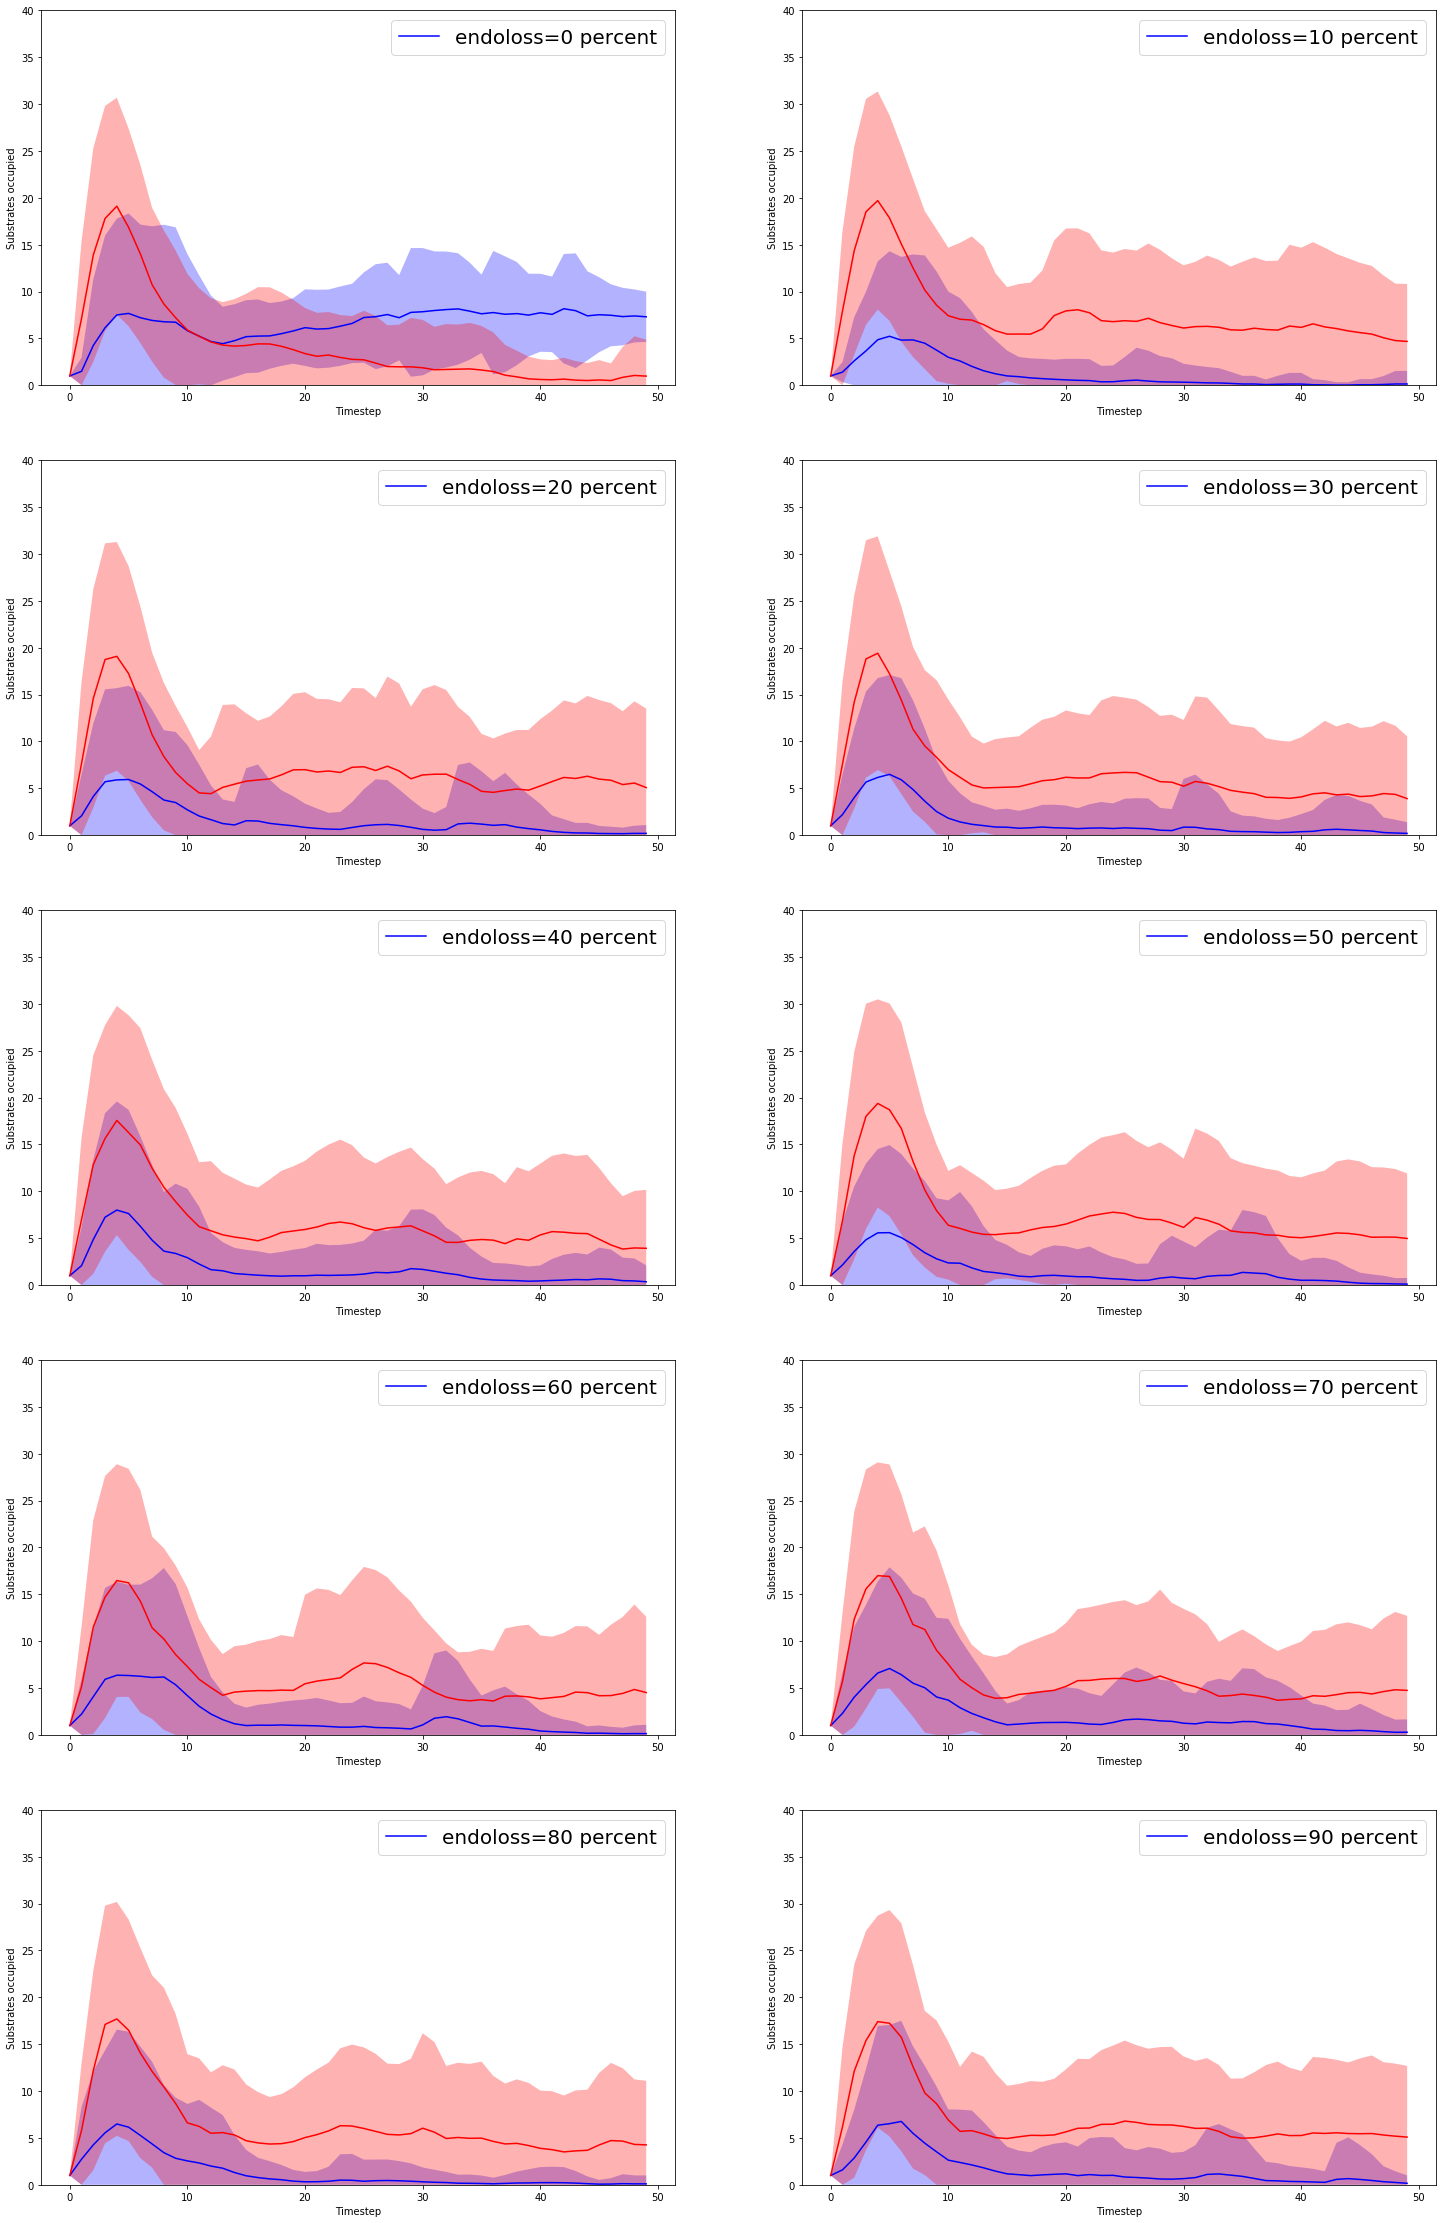

In [16]:
x = list(range(50))
fig, axes = plt.subplots(5,2, figsize=(25, 40)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_ylim(0,40) ## yaxis
    ## plot blue:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
            c='blue',
            label=('endoloss=%s percent' %lvls[i]),
            )
    ## blue error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    ## plot red:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
            c='red',
            #label=('d=%s' %lvls[i]),
            )
    ## red error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='red',
                    alpha = 0.3,
                    )
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")


[back to contents](#contents)

<a id='deforestation'></a>

## Deforestation 

We can see how these EC+ and EC-  compete after dispersing to a new harvest event, modeled as a lot of fresh slash on the ground, and increasingly fewer trees on the landscape. We do this by lowering the "kappa" setting in our model, which is the number of clusters of trees on the landscape. This is a little different than looking at what happens to a landscape with existing fungi in the leaves and on the forest floor (for that I would have to modify the model a little, to allow tree death...).

In [ ]:
mpiexec -n 10 python3 runFA.py -endodisp 2 -sims 10 -decompdisp 0 -numdecomp 0 -ws 20 -sweepname initialwood20
mpiexec -n 10 python3 runFA.py -endodisp 2 -sims 10 -decompdisp 0 -numdecomp 0 -ws 40 -sweepname initialwood40
mpiexec -n 10 python3 runFA.py -endodisp 2 -sims 10 -decompdisp 0 -numdecomp 0 -ws 60 -sweepname initialwood60

In [18]:
runs = pd.read_pickle('sweeps/results/deforest_kappa_labcomp.p')